In [5]:
import numpy as np
from scipy.special import expit
import sys
from sklearn.metrics import roc_auc_score, accuracy_score,r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy.stats import pearsonr

In [6]:
def calc_precip(q, rho, z):
# surface precipitation rate given tendency of specific humidity
    precip = -vertical_integral(q, rho, z)
    return precip

def vertical_integral(data, rho, z):
# vertical integral with respect to sigma
    rho_dz = vertical_diff(rho, z)
    int_data = np.sum(data * rho_dz[None,:], axis=1)
    return int_data

def vertical_diff(rho, z):
    # follow vertical differencing from setgrid.f90 in SAM
    # changed indexing from starting at 1 to 0
    nzm = z.size
    adz = np.zeros(nzm)    
    dz = 0.5*(z[0]+z[1]) 
    adz[0] = 1.
    for k in range(1,nzm-1): # range doesn't include stopping number
       adz[k] = 0.5*(z[k+1]-z[k-1])/dz

    adz[nzm-1] = (z[nzm-1]-z[nzm-2])/dz

    rho_dz = adz*dz*rho

    return rho_dz

In [7]:
save_path = '/Users/yani/Dropbox/MIT/projects/Plotting_data'
#path to data file 
# filename = '/Users/yani/Dropbox/MIT/projects/Plotting_data/qobskm12x576_576x1440x48_ctl_288_0001754100_0001_diff_coarse_space_corrected_tkz16.nc4'
filename = '/Users/yani/Dropbox/MIT/projects/Plotting_data/qobskm12x576_576x1440x48_ctl_288_0001754100_0001_diff_coarse_space_corrected_tkz8.nc4'

f = Dataset(filename, mode='r')
x = f.variables['x'][:] # m
y = f.variables['y'][:] # m
z = f.variables['z'][:] # m
p = f.variables['p'][:] # hPa
f.close()

In [8]:
f = Dataset(filename, mode='r')

x = f.variables['x'][:] # m
y = f.variables['y'][:] # m
z = f.variables['z'][:] # m
p = f.variables['p'][:] # hPa
f.close()

## Get calculated R^2 from the whole 3D test dataset (225 times steps)

In [14]:
# On github the R^2 files are found in /data_offline/r2_data directory

import pickle
no_c_grid = False
if no_c_grid:
    pkl_file_x8_R2_file = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_offline_R2_calc_over_all_test/r2_full_for_momentum_x8_no_c_grid_501_snapshots.pkl'
else:
#     pkl_file_x8_R2_file = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_offline_R2_calc_over_all_test/r2_full_for_momentum_x8.pkl'
    pkl_file_x8_R2_file = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_offline_R2_calc_over_all_test/r2_full_for_momentum_x8_with_c_grid_501_snapshots.pkl'
data_l = pickle.load(open(pkl_file_x8_R2_file, 'rb'))
mom_u_r2 = data_l[:,15:15+47]
mom_v_r2 = data_l[:,15+47:15+47+47]

In [15]:
if no_c_grid:
    pkl_file_x8_R2_file = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_offline_R2_calc_over_all_test/r2_full_for_momentum_x8_no_c_grid_501_snapshots_ABS.pkl'
else:
    pkl_file_x8_R2_file = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/data_offline_R2_calc_over_all_test/r2_full_for_momentum_x8_with_c_grid_501_snapshots_ABS.pkl'
data_l = pickle.load(open(pkl_file_x8_R2_file, 'rb'))
mom_u_r2_abs = data_l[:,15:15+47]
mom_v_r2_abs = data_l[:,15+47:15+47+47]

## Get R^2 for energy and moisture for comparison to momentum

In [16]:
filename_x8_NN_offline = '/Users/yani/Dropbox/MIT/projects/NN_parameterization/Offline_x8/qobsTTFFFFFTF30FFTFTF30TTFTFTFFF80FFTFTTF2699FFFF_X01_no_qp_no_adv_surf_F-Stan_O-Stan_Ntr13856040_Nte729360_F_Tin_qin_disteq_O_Trad_rest_Tadv_qadv_qout_qsed_RESCALED_7epochs_no_drop_NN_layers5in61out148_BN_F_te70_tr70/data_test.nc'
f = Dataset(filename_x8_NN_offline, mode='r')

Tadv_Rsq = f.variables['Tadv_Rsq'][:] # hPa
qadv_Rsq = f.variables['qadv_Rsq'][:] # hPa

f.close()

In [17]:
from scipy.stats import pearsonr
def plot_R2_offline_u_v_T_q_u_abs_v_abs(u_r2,v_r2,u_r2_abs,v_r2_abs,T_r2,q_r2,y_plot,Rsq_scale1 = 0.9,Rsq_scale2 = 0.9,save_name = 'dummy'):
    per_day = 3600*24
    fontsize = 12
    fontsize_legend = 8
    ticks_lat = [-5,0,5]
    upper_level_p = 48
    lowest_level = 1


    # ticks_pmean = [0,0.2,0.4,0.6,0.8]
    # ticks_px = ticks_pmean #np.arange(0,900,100)

    # ticks_px_offline = ticks_pmean
    # ticks_pmean_offline = ticks_pmean

    cmap1 = 'bwr'
    # linewidth=1.5
    Rsq_levs = np.arange(-0.1,Rsq_scale1,0.05)
    Rsq_levs_tkz = np.arange(-0.1,Rsq_scale2,0.05)
    Rsq_levs_ticks = np.arange(-0.1,Rsq_scale1,0.2)
#     Rsq_levs_tkz = np.arange(-0.1,Rsq_scale2,0.2)
    mean_levs = np.arange(-0.00001,0.00001,0.00001/20)

    h_width = 0.1
    v_width = 0.1
    h_width_cbar = 0.02
    colorbar_width =0.02

    row_dim = 3
    col_dim = 2

    fig_witdth = 0.45
    fig_height = 0.5
    fig_h_dist = 0.25
    fig_v_dist = 0.1

    letters = ["(a) Zonal momentum flux","(b) Meridional momentum flux","(c) Energy flux ","(d) Moisture flux",'(e) tkx Rsq','']
    letters = ["(a) Zonal momentum flux","(b) Meridional momentum flux","(c) Absolute value zonal momentum flux","(d) Absolute value meridional momentum flux","(e) Energy flux ","(f) Moisture flux",'(e) tkx Rsq','']
    # letters = ["(a)" + 'pearson:' + str(round(corr_paramet,3)),"(b)","(b)" + 'pearson:' + str(round(corr_paramet_RF,3)),"(d)"]
    # headers = ["$q_t$ tend" +str(r2[0]),"26 lev (48 inputs) $R^2=$"+str(r2[1]),"38 lev $R^2=$"+str(r2[2]),"48 lev $R^2=$"+str(r2[3])]

    colors1 = ['red','black','blue','green']
    fig, axes = plt.subplots(row_dim,col_dim)

#     cax_mean_online2 =axes[0,0].contour(y_plot,p,Rsq_dict['uRsq'].T,levels =0,colors='black')
    cax_mean_online1 =axes[0,0].contourf(y_plot,p[:-1],u_r2.T,Rsq_levs,extend='both')#,cmap=cmap1)
    axes[0, 0].set_ylim(np.amax(p), np.amin(p))

#     cax_mean_online3 =axes[1,0].contour(y_plot,p,Rsq_dict['vRsq'].T,levels =0,colors='black')
    cax_mean_online2 =axes[0,1].contourf(y_plot,p[:-1],v_r2.T,Rsq_levs,extend='both')#,cmap=cmap1)
#     cax_mean_online3 =axes[1,0].contourf(y_plot,p,Rsq_dict['vRsq'].T,Rsq_levs,cmap=cmap1)
    axes[0, 1].set_ylim(np.amax(p), np.amin(p))

    #     cax_mean_online2 =axes[0,0].contour(y_plot,p,Rsq_dict['uRsq'].T,levels =0,colors='black')
    cax_mean_online3 =axes[1,0].contourf(y_plot,p[:-1],u_r2_abs.T,Rsq_levs,extend='both')#,cmap=cmap1)
    axes[1, 0].set_ylim(np.amax(p), np.amin(p))

#     cax_mean_online3 =axes[1,0].contour(y_plot,p,Rsq_dict['vRsq'].T,levels =0,colors='black')
    cax_mean_online4 =axes[1,1].contourf(y_plot,p[:-1],v_r2_abs.T,Rsq_levs,extend='both')#,cmap=cmap1)
#     cax_mean_online3 =axes[1,0].contourf(y_plot,p,Rsq_dict['vRsq'].T,Rsq_levs,cmap=cmap1)
    axes[1, 1].set_ylim(np.amax(p), np.amin(p))

    
#     cax_mean_online4 =axes[2,0].contour(y_plot,p,Rsq_dict['tkzRsq'].T,levels =0,colors='black')
    cax_mean_online5 =axes[2,0].contourf(y_plot,p[:],T_r2.T,Rsq_levs,extend='both')#,cmap=cmap1)
    axes[2, 0].set_ylim(np.amax(p), np.amin(p))
    
    cax_mean_online6 =axes[2,1].contourf(y_plot,p[:],q_r2.T,Rsq_levs,extend='both')#,cmap=cmap1)
    axes[2, 1].set_ylim(np.amax(p), np.amin(p))
    


    # fig.delaxes(axes[1,0])
#     fig.delaxes(axes[2,0])
    # fig.delaxes(axes[0,1])
    # fig.delaxes(axes[1,1])
    #Position of first figure        
    x0 = axes[0,0].get_position().x0
    x1 = axes[0,0].get_position().x1
    y0 = axes[0,0].get_position().y0
    y1 = axes[0,0].get_position().y1

    for i in range(row_dim):
        for j  in range(col_dim):
            axes[i,j].set_position([x0 + j*fig_witdth + j*fig_h_dist,y0- i*fig_height - i*fig_v_dist,fig_witdth,fig_height])


    ind_let = 0
    for i in range(row_dim):
        for j  in range(col_dim):
            atext2 = axes[i, j].text(axes[0,0].get_position().x0*1+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.86- (i-1)*fig_height - (i-1)*fig_v_dist ,letters[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)

    #         header= axes[i, j].text(axes[0,0].get_position().x0*1.5+ j*fig_witdth + j*fig_h_dist,axes[0,0].get_position().y0*0.92- (i-1)*fig_height - (i-1)*fig_v_dist ,headers[ind_let],transform = fig.transFigure,color="black",fontsize=fontsize)
            ind_let = ind_let + 1

    # v = np.arange(-0.3,0.8,0.1)
    pos1_rsq = axes[0, 0].get_position() # get the original position 
    cbaxes_rsq = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq = fig.colorbar(cax_mean_online1,cax = cbaxes_rsq, ax=axes[0,0], shrink=1.0,ticks=Rsq_levs_ticks)
    # cbar_rsq.ax.set_xlabel('$[kg/kg/day]$', fontsize=fontsize)
    # cbar_rsq.clim(-0.3, 1);
    cbar_rsq.ax.tick_params(labelsize=fontsize)
    
    pos1_rsq = axes[1, 0].get_position() # get the original position 
    cbaxes_rsq2 = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq2 = fig.colorbar(cax_mean_online2,cax = cbaxes_rsq2, ax=axes[1,0], shrink=1.0,ticks=Rsq_levs_ticks)
    # cbar_rsq2.clim(-0.3, 1);
    cbar_rsq2.ax.tick_params(labelsize=fontsize)
    
    pos1_rsq = axes[0, 1].get_position() # get the original position 
    cbaxes_rsq2 = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq2 = fig.colorbar(cax_mean_online3,cax = cbaxes_rsq2, ax=axes[0,1], shrink=1.0,ticks=Rsq_levs_ticks)
    cbar_rsq2.ax.tick_params(labelsize=fontsize)
    
    
    pos1_rsq = axes[1, 1].get_position() # get the original position 
    cbaxes_rsq2 = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq2 = fig.colorbar(cax_mean_online4,cax = cbaxes_rsq2, ax=axes[1,1], shrink=1.0,ticks=Rsq_levs_ticks)
    cbar_rsq2.ax.tick_params(labelsize=fontsize)

    pos1_rsq = axes[2, 0].get_position() # get the original position 
    cbaxes_rsq2 = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq2 = fig.colorbar(cax_mean_online5,cax = cbaxes_rsq2, ax=axes[2,0], shrink=1.0,ticks=Rsq_levs_ticks)
    cbar_rsq2.ax.tick_params(labelsize=fontsize)
    
    pos1_rsq = axes[2, 1].get_position() # get the original position 
    cbaxes_rsq2 = fig.add_axes([pos1_rsq.x0+pos1_rsq.width + h_width_cbar, pos1_rsq.y0, colorbar_width, fig_height]) 
    cbar_rsq2 = fig.colorbar(cax_mean_online6,cax = cbaxes_rsq2, ax=axes[2,1], shrink=1.0,ticks=Rsq_levs_ticks)
    cbar_rsq2.ax.tick_params(labelsize=fontsize)

    
    axes[2, 0].set_xlabel('Latitude',fontsize=fontsize)
    axes[2, 1].set_xlabel('Latitude',fontsize=fontsize)
    # axes[1, 0].set_xlabel('RF prediction @ (9km)',fontsize=fontsize)


    axes[2, 0].set_ylabel('pressure [hPa]',fontsize=fontsize)

    axes[1, 0].set_ylabel('pressure [hPa]',fontsize=fontsize)
    # axes[1, 0].set_ylabel('True u tend @ (9km) [m s$^{-2}$]',fontsize=fontsize)

    axes[0, 0].set_ylabel('pressure [hPa]',fontsize=fontsize)

    
    
    ticks_lat_degrees = ['$-45^\circ$','$0^\circ$','$45^\circ$']
    ticks_lat = [-5,0,5]
    fontsize_ticks = 12
    axes[1, 0].set_xticks(ticks_lat)
    axes[1, 0].set_xticklabels([])
    axes[1, 1].set_xticks(ticks_lat)
    axes[1, 1].set_xticklabels([])

    axes[2, 0].set_xticks(ticks_lat)
    axes[2, 0].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)
    axes[2, 1].set_xticks(ticks_lat)
    axes[2, 1].set_xticklabels(ticks_lat_degrees,fontsize=fontsize_ticks)

    
    
    axes[0, 0].set_xticks(ticks_lat)
    axes[0, 0].set_xticklabels([])
    axes[0, 1].set_xticks(ticks_lat)
    axes[0, 1].set_xticklabels([])
    
    
    ticks_pressure = [300,600,900]

    fontsize_ticks = 12
    axes[0, 0].set_yticks(ticks_pressure)
    axes[0, 0].set_yticklabels(ticks_pressure,fontsize=fontsize_ticks)
    axes[1, 0].set_yticks(ticks_pressure)
    axes[1, 0].set_yticklabels(ticks_pressure,fontsize=fontsize_ticks)
    axes[2, 0].set_yticks(ticks_pressure)
    axes[2, 0].set_yticklabels(ticks_pressure,fontsize=fontsize_ticks)

    axes[2, 1].set_yticks(ticks_pressure)
    axes[2, 1].set_yticklabels([])
    axes[1, 1].set_yticks(ticks_pressure)
    axes[1, 1].set_yticklabels([])
    axes[0, 1].set_yticks(ticks_pressure)
    axes[0, 1].set_yticklabels([])

#     fig.delaxes(axes[2,1])
#     fig.delaxes(axes[2,0])
#     axes[0,1].spines["top"].set_visible(False)
#     axes[0,1].spines["right"].set_visible(False)

#     axes[1,1].spines["top"].set_visible(False)
#     axes[1,1].spines["right"].set_visible(False)

#     axes[1,0].spines["top"].set_visible(False)
#     axes[1,0].spines["right"].set_visible(False)

    
    # #Saving plot... f
    # save_path = '/Users/yani/Dropbox/MIT/projects/Plotting_data/'
    save_path = '/Users/yani/Dropbox/MIT/projects/ML_momentum_data/Latex_paper/plots/'


#
    plt.savefig(save_path+save_name+'.eps', format='eps', bbox_inches="tight")








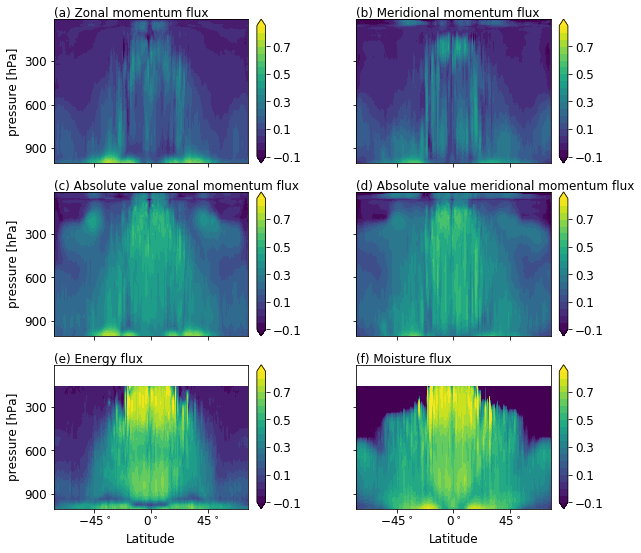

In [12]:
y_plot = (y - np.mean(y))/10**6
plot_R2_offline_u_v_T_q_u_abs_v_abs(mom_u_r2,mom_v_r2,mom_u_r2_abs,mom_v_r2_abs,Tadv_Rsq,qadv_Rsq,y_plot,Rsq_scale1 = 0.9, save_name='Compare_Rsq_u_v_u_abs_v_abs_q_T_no_c_grid')